## Due to inelastic scattering from monochromator, elastic lineshape persists in the inelastic channel. 

Elastic lineshape takes the following form 

$I_{el}(Q,\omega) = A(\omega)(\sigma_{bragg}(Q)+\sigma_{inc})$

Where the factor A($\omega$) is found using the magnitude of the bragg peak as a function of energy transfer. In order to model the magnetic contribution to the signal as a function of energy transfer, we assume a nearest neighbor correlation. Then, for every energy transfer we may model the contributions the scattering as 

$I_{obs}(Q,\omega) = A(\omega)(\sigma_{bragg}(Q) + \sigma_{inc})+B(\omega)|F(Q)|^2 \frac{1+\sin (Qd)}{Qd}+I_{ph}(Q,\omega)$

Where $|F(Q)|^2$ is the magnetic form factor for Ir$^{4+}$, $I_{ph}(Q,\omega)$ is the phonon contribution, and $d$ is the nearest-neighbor length of 3.54 Angstrom. The phonon contribution may be removed in the following way:

$\bar{I}(Q,\omega) = I_{obs}^{T_L}(Q,\omega) - \frac{1-e^{-\beta_{T_H} \omega}}{1-e^{-\beta_{T_L} \omega}}I_{obs}^{T_H}(Q,\omega)$

$\bar{I}(Q,\omega) = (1.0-A(\omega))(\sigma_{bragg}(Q) + \sigma_{inc})+B(\omega)|F(Q)|^2 \frac{1+\sin (Qd)}{Qd}$

This assumes that there exists no magnetic scattering at T=55 K, and that the elastic scattering is a constant as a function of temperature. 

We may also assume that the lowest energy scattering as a function of $Q$ is a good measure of $I_{el}(Q)=(\sigma_{bragg}(Q)+\sigma_{inc})$. Then, we may fit for the constants $A(\omega)$ and $B(\omega)$ as functions of energy transfer leaving only the magnetic scattering.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mantid.simpleapi import *
import matplotlib

import os
import sys
sys.path.append("../python scripts/")

#Import the functions in this directofrom nxspetomd import *
from genslices import *
import MDUtils as mdu
from getcolor import *
import lmfit
from lmfit import Model
from mdfactorization import *
from submultscatt import *
from tempsubtract import * 
from cut_mdhisto_powder import *
from tempsubtract_nearest import *
from mantidFF import get_MANTID_magFF
import matplotlib.patheffects as PathEffects
import scipy

%matplotlib inline

plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'


FrameworkManager-[Notice] Welcome to Mantid 6.9.1
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.9.1
CheckMantidVersion-[Notice] A new version of Mantid(6.10.0) is available for download from https://download.mantidproject.org
DownloadInstrument-[Notice] All instrument definitions up to date


In [2]:
keys = ['2K_3p7','55K_3p7','2K_5p0','55K_5p0']
f_dict = {keys[0]:'../MDHisto_files/macs_3p7_2K.nxs',\
         keys[1]:'../MDHisto_files/macs_3p7_55K.nxs',\
         keys[2]:'../MDHisto_files/macs_5p0_2K.nxs',\
         keys[3]:'../MDHisto_files/macs_5p0_55K.nxs'}
#Import the data into workspaces. 
ws_dict = {}
Ef_dict = {keys[0]:3.7,keys[1]:3.7,keys[2]:3.7,keys[3]:3.7}

for key in keys:
    f = f_dict[key]
    ws = LoadMD(f,OutputWorkspace=key)
    
#Perform the temperature subtraction
Ibar_3p7 = tempsubtract_nearest_cut2D(mtd['2K_3p7'],mtd['55K_3p7'],1.7,55.0)
Ibar_3p7 = CloneWorkspace(Ibar_3p7,OutputWorkspace='Ibar_3p7')
Ibar_5p0 = tempsubtract_nearest_cut2D(mtd['2K_5p0'],mtd['55K_5p0'],1.7,55.0)
Ibar_5p0 = CloneWorkspace(Ibar_5p0,OutputWorkspace='Ibar_5p0')
#mixed them up...


LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.05 seconds
LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.04 seconds
LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.07 seconds
LoadMD-[Notice] LoadMD started
LoadMD-[Notice] LoadMD successful, Duration 0.04 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
C

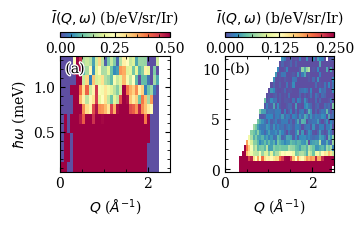

In [3]:
#Make plots of Ibar

fig,ax = plt.subplots(1,2,figsize=(3.54,1.5),subplot_kw={'projection':'mantid'})
fig.subplots_adjust(hspace=0.2,wspace=0.5)
mesh1 = ax[0].pcolormesh(Ibar_3p7,vmin=0,vmax=0.5,cmap='Spectral_r',rasterized=True)
mesh2 = ax[1].pcolormesh(Ibar_5p0,vmin=0,vmax=0.25,cmap='Spectral_r',rasterized=True)
ax[1].set_ylabel('')
ax[0].set_ylabel('$\hbar\omega$ (meV)')
ax[0].set_xlabel('$Q$ ($\AA^{-1}$)')
ax[1].set_xlabel('$Q$ ($\AA^{-1}$)')

ax[0].set_xlim(0,2.5)
ax[1].set_xlim(0,2.5)

txta = ax[0].text(0.05,0.95,"(a)",transform=ax[0].transAxes,horizontalalignment='left',verticalalignment='top')
txtb = ax[1].text(0.05,0.95,"(b)",transform=ax[1].transAxes,horizontalalignment='left',verticalalignment='top')
for txt in [txta,txtb]:
    txt.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Put a colorbar on top of each
l,b,w,h=ax[0].get_position().bounds
cax1 = fig.add_axes([l,b+0.9,w,0.03])
l,b,w,h=ax[1].get_position().bounds
cax2 = fig.add_axes([l,b+0.9,w,0.03])
cbar1 = fig.colorbar(mesh1,cax=cax1,orientation='horizontal')
cax1.text(0.5,2,r'$\bar{I} (Q,\omega)$ (b/eV/sr/Ir)',horizontalalignment='center',verticalalignment='bottom',\
         transform=cax1.transAxes)
cbar2 = fig.colorbar(mesh2,cax=cax2,orientation='horizontal',ticks=[0,0.125,0.25])
cax2.text(0.5,2,r'$\bar{I} (Q,\omega)$ (b/eV/sr/Ir)',horizontalalignment='center',verticalalignment='bottom',\
         transform=cax2.transAxes)
fig.savefig('Ibar_macs_fig.pdf',bbox_inches='tight',dpi=400)
plt.show()

## Now, we desire a form for $\sigma_{bragg}(Q) + \sigma_{inc}$. We do so using the lowest avaiable energy transfers and assume no magnetic scattering 

CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.03 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.01 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.01 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.01 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.00 seconds
MagFormFactorCorrection-[Notice] Mag

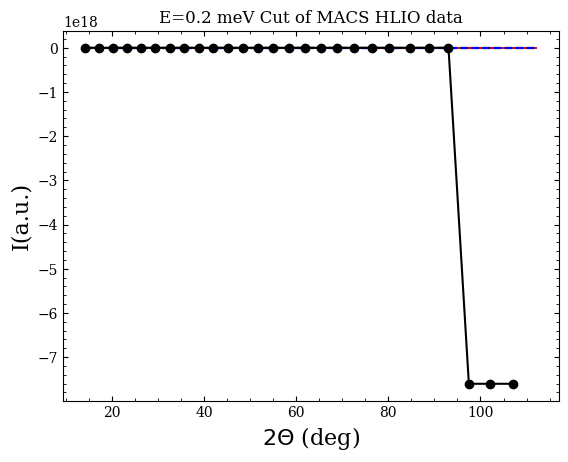

In [4]:
def gaussian(x,a,x0,sigma):
    return (a/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-(x-x0)**2 / (2.0*(sigma**2)))

#Require three gaussians to model the main bragg peak. 
#Start with Ei = 3.7. 

q3_mag,I3_mag,ErrQ3_mag = cut_MDHisto_powder(Ibar_3p7,'|Q|',[0.3,2.5,0.01],[-0.1,0.21])

def incoherent(x,a):
    return np.ones(len(x))*a
def fake_phonon(q,P):
    return P*(q**2)
def mag(q,b):
    #Uses the extracted correlations found on SEQ
    q,ff = get_MANTID_magFF(q,'Ir4')
    ff = 1.0/ff 
    return b*ff*(1.0+np.sin(q*3.59)/(q*3.59))
def fake_phonon(q,P):
    return P*(q**2)
#Convert Q to 2theta
e_arr = mdu.dim2array(Ibar_3p7.getNonIntegratedDimensions()[1])
etrans = e_arr[0]
Ef = 3.7
Ei = Ef + etrans
ki = np.sqrt(Ei/2.07)
kf = np.sqrt(Ef/2.07)

twoTheta = np.arccos((ki**2 + kf**2 - q3_mag**2 )/ (2.0*ki*kf))*180.0/np.pi
twoTheta3=np.copy(twoTheta)
HLIO_el_model = Model(gaussian,prefix='g1_',independent_vars=['x'])+\
                Model(gaussian,prefix='g2_',independent_vars=['x'])+\
                Model(gaussian,prefix='g3_',independent_vars=['x'])+\
                Model(incoherent,prefix='inc_',indpendent_vars=['x'])+\
                Model(mag,prefix='mag_',indepdendent_vars=['q'])+\
                Model(fake_phonon,prefix='ph_',independent_vars=['q'])

HLIO_el_params=HLIO_el_model.make_params()
HLIO_el_params.add('g1_a',value=1915.0,min=0,max=1e4)
HLIO_el_params.add('g1_x0',value=61.0,min=55.0,max=75.0)
HLIO_el_params.add('g1_sigma',value=2.0,min=1.0,max=5.2)
HLIO_el_params.add('g2_a',value=1775.0,min=0,max=1e4)
HLIO_el_params.add('g2_x0',value=71.2,min=55.0,max=85.0)
HLIO_el_params.add('g2_sigma',value=11.5,min=1.0,max=5.2)
#HLIO_el_params.add('g2_sigma',expr='g1_sigma')
HLIO_el_params.add('g3_a',value=1863.0,min=0,max=1e4)
HLIO_el_params.add('g3_x0',value=63.1,min=55.0,max=75.0)
HLIO_el_params.add('g3_sigma',value=4.4,min=2.0,max=5.2)
#HLIO_el_params.add('g3_sigma',expr='g1_sigma')
HLIO_el_params.add('inc_a',value=56.0,min=0.0,max=1e5)
HLIO_el_params.add('mag_b',vary=False,value=0.0,min=0,max=1e4)
HLIO_el_params.add('ph_P',vary=False,value=0,min=0,max=1e3)
weights = 1.0/ErrQ3_mag
weights[np.isinf(weights)]=0
weights[np.isnan(weights)]=0
weights[twoTheta<20.0]=0
weights[twoTheta>95.0]=0
I3_elplot = np.copy(I3_mag)
I3_elplot[twoTheta>110]=np.nan

I3_mag[weights==0]=0
HLIO_result = HLIO_el_model.fit(I3_mag,x=twoTheta,q=q3_mag,weights=weights,\
                                params=HLIO_el_params,method='powell',nan_policy='omit')
comps = HLIO_result.eval_components(x=twoTheta,q=q3_mag)
hlio_3_interp = scipy.interpolate.interp1d(twoTheta,I3_mag,fill_value='extrapolate')
print(HLIO_result.fit_report())
plt.figure()
plt.errorbar(twoTheta,I3_elplot,yerr=ErrQ3_mag,color='k',marker='o')
plt.plot(twoTheta,HLIO_el_model.eval(x=twoTheta,q=q3_mag,params=HLIO_result.params),'r-')
plt.plot(twoTheta,comps['g1_'],'c--')
plt.plot(twoTheta,comps['g2_'],'m--')
plt.plot(twoTheta,comps['g3_'],'g--')
plt.plot(twoTheta,comps['inc_'],'b--')

plt.xlabel('$2\Theta$ (deg)',fontsize=16)
plt.ylabel('I(a.u.)',fontsize=16)
plt.title('E=0.2 meV Cut of MACS HLIO data')
plt.show()


CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.03 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.01 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.01 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.01 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.00 seconds
MagFormFactorCorrection-[Notice] Mag

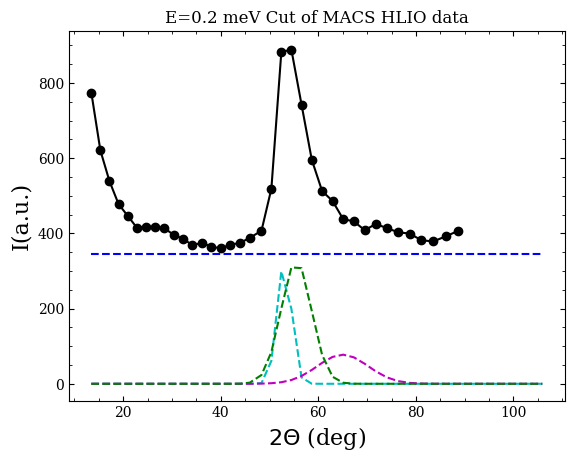

In [5]:
#Do the same for the Ef 5 meV

q5_mag,I5_mag,ErrQ5_mag = cut_MDHisto_powder(Ibar_5p0,'|Q|',[0.3,3.5,0.01],[-0.1,0.5])

def incoherent(x,a):
    return np.ones(len(x))*a
def fake_phonon(q,P):
    return P*(q**2)
def mag(q,b):
    #Uses the extracted correlations found on SEQ
    q,ff = get_MANTID_magFF(q,'Ir4')
    ff = 1.0/ff 
    return b*ff*(1.0+np.sin(q*3.59)/(q*3.59))

#Convert Q to 2theta
e_arr = mdu.dim2array(Ibar_5p0.getNonIntegratedDimensions()[1])
etrans = e_arr[0]
Ef = 5.0
Ei = Ef + etrans
ki = np.sqrt(Ei/2.07)
kf = np.sqrt(Ef/2.07)

twoTheta5 = np.arccos((ki**2 + kf**2 - q5_mag**2 )/ (2.0*ki*kf))*180.0/np.pi
twoTheta5=np.copy(twoTheta5)
HLIO_el_model5 = Model(gaussian,prefix='g1_',independent_vars=['x'])+\
                Model(gaussian,prefix='g2_',independent_vars=['x'])+\
                Model(gaussian,prefix='g3_',independent_vars=['x'])+\
                Model(incoherent,prefix='inc_',indpendent_vars=['x'])+\
                Model(mag,prefix='mag_',indepdendent_vars=['q'])+\
                Model(fake_phonon,independent_vars=['q'])

HLIO_el_params5=HLIO_el_model.make_params()
HLIO_el_params5.add('g1_a',value=1915.0,min=0,max=1e5)
HLIO_el_params5.add('g1_x0',value=41.0,min=40.0,max=65.0)
HLIO_el_params5.add('g1_sigma',value=2.0,min=1.0,max=5.2)
HLIO_el_params5.add('g2_a',value=1775.0,min=0,max=1e5)
HLIO_el_params5.add('g2_x0',value=50.2,min=45.0,max=65.0)
HLIO_el_params5.add('g2_sigma',value=11.5,min=1.0,max=5.2)
#HLIO_el_params.add('g2_sigma',expr='g1_sigma')
HLIO_el_params5.add('g3_a',value=1863.0,min=0,max=1e5)
HLIO_el_params5.add('g3_x0',value=48.1,min=45.0,max=65.0)
HLIO_el_params5.add('g3_sigma',value=4.4,min=1.0,max=5.2)
#HLIO_el_params.add('g3_sigma',expr='g1_sigma')
HLIO_el_params5.add('inc_a',value=56.0,min=10.0,max=1e5)
HLIO_el_params5.add('mag_b',vary=True,value=0.0,min=0,max=1e4)
HLIO_el_params5.add('P',vary=False,value=0.0,min=0.0,max=1e3)
weights5 = 1.0/ErrQ5_mag
weights5[np.isinf(weights5)]=0
weights5[np.isnan(weights5)]=0
weights5[twoTheta5<20.0]=0
weights5[twoTheta5>85.0]=0
I5_elplot = np.copy(I5_mag)
I5_elplot[twoTheta5>90]=np.nan

I5_mag[weights5==0]=0
HLIO_result5 = HLIO_el_model5.fit(I5_mag,x=twoTheta5,q=q5_mag,weights=weights5,\
                                params=HLIO_el_params5,method='powell',nan_policy='omit')
comps5 = HLIO_result5.eval_components(x=twoTheta5,q=q5_mag)
hlio_5_interp = scipy.interpolate.interp1d(twoTheta5,I5_mag,fill_value='extrapolate')
print(HLIO_result5.fit_report())
plt.figure()
plt.errorbar(twoTheta5,I5_elplot,yerr=ErrQ5_mag,color='k',marker='o')
plt.plot(twoTheta5,HLIO_el_model.eval(x=twoTheta5,q=q5_mag,params=HLIO_result5.params),'r-')
plt.plot(twoTheta5,comps5['g1_'],'c--')
plt.plot(twoTheta5,comps5['g2_'],'m--')
plt.plot(twoTheta5,comps5['g3_'],'g--')
plt.plot(twoTheta5,comps5['inc_'],'b--')

plt.xlabel('$2\Theta$ (deg)',fontsize=16)
plt.ylabel('I(a.u.)',fontsize=16)
plt.title('E=0.2 meV Cut of MACS HLIO data')
plt.show()


# Using the resulting lineshapes, we now track the intensity of the Bragg peak as a function of energy transfer to remove the elastic scattering. 

CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.02 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.02 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.01 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.01 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.00 seconds
MagFormFactorCorrection-[Notice] Mag

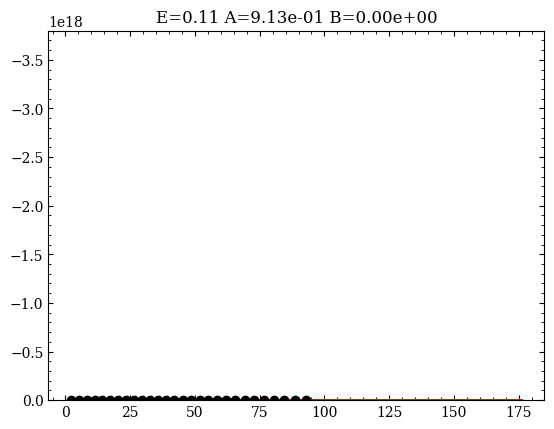

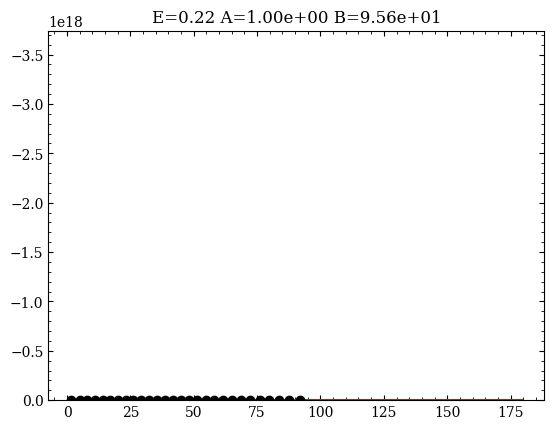

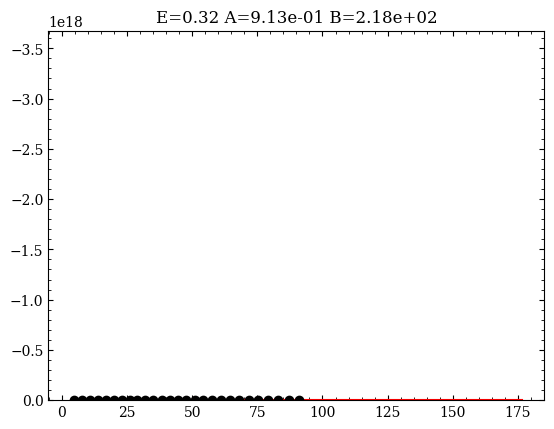

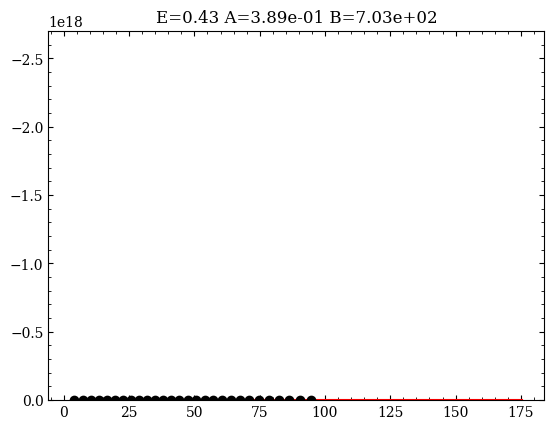

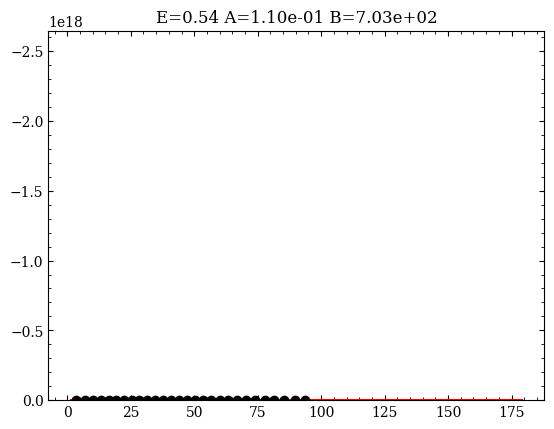

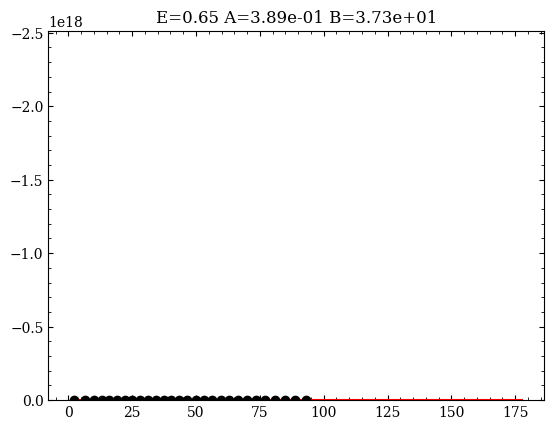

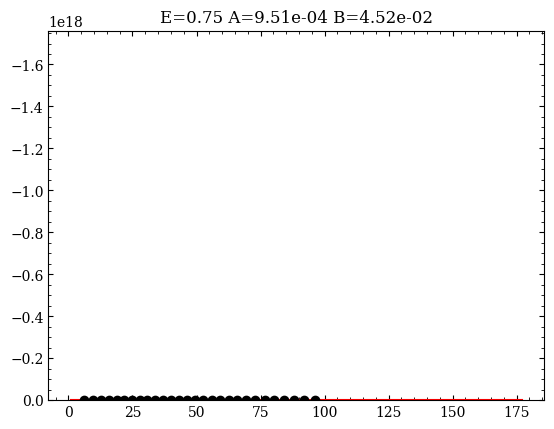

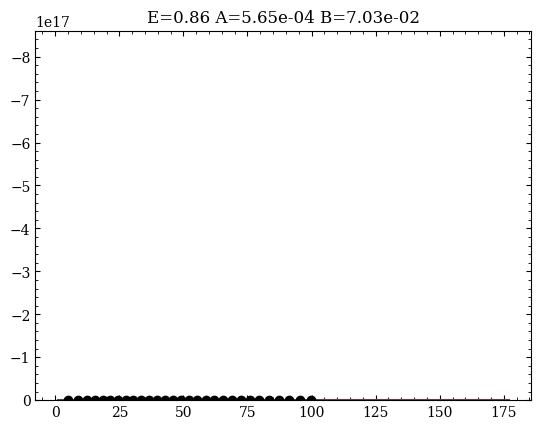

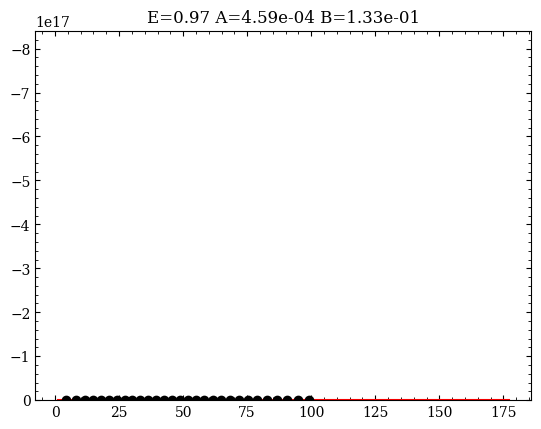

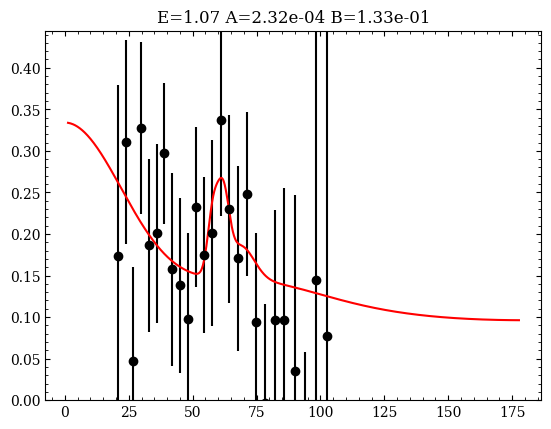

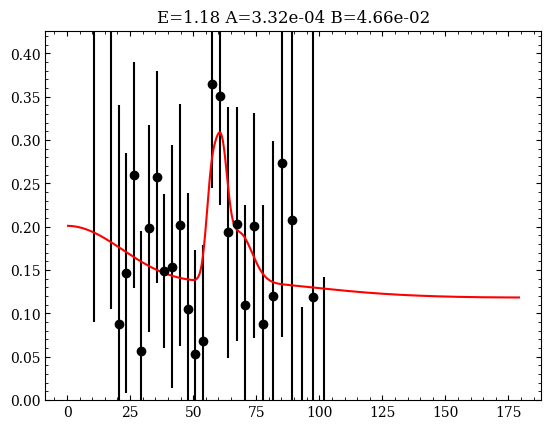

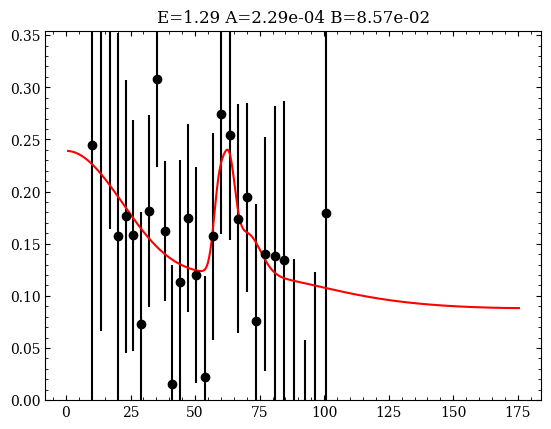

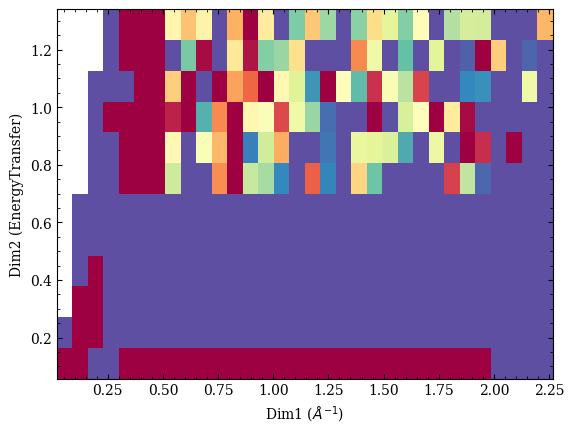

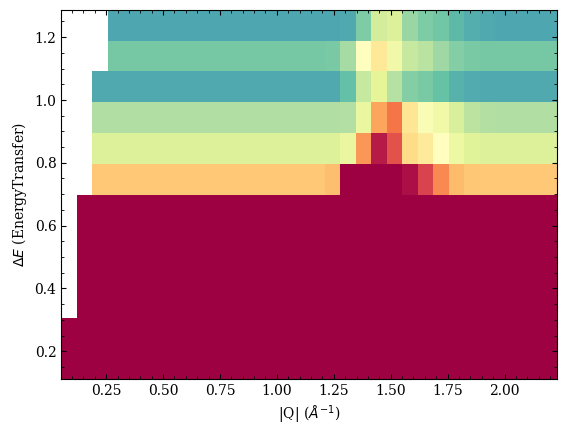

In [6]:
plt.close('all')
def el_line(x,q,A,delta,old_model=HLIO_el_model,old_result=HLIO_result):
    #Using the previous fits, simply scale the overall lineshape. 
    old_params = old_result.params
    elline_eval=old_model.eval(x=x-delta,q=q,params=old_params)
    return A*elline_eval
def fake_phonon(q,P):
    return P*(q**2)
inel_model = Model(el_line,independent_vars=['q','x'])\
        +Model(mag,independent_vars=['q'])+Model(fake_phonon,independent_vars=['q'])
inel_params = inel_model.make_params()
inel_params.add('A',value=1.0,min=0.0,max=50.0)
inel_params.add('delta',vary=True,value=0.0,min=-4.0,max=4.0)#allow small shift of main peak
inel_params.add('b',value=0.0,min=0.0,max=1000.0)
inel_params.add('P',vary=True,value=0.0,min=0.0,max=100.0)

#Using the previous lineshape, now only fit the relative bragg peak intensity as a function of energy transfer
I = np.copy(Ibar_3p7.getSignalArray())
I_out = np.copy(I)
Bkg = np.copy(I)
Errs = np.sqrt(np.copy(Ibar_3p7.getErrorSquaredArray()))
dims = Ibar_3p7.getNonIntegratedDimensions()
q = mdu.dim2array(dims[0])
e = mdu.dim2array(dims[1])

delta3_arr = []
A3_arr=[]
B_arr=[]
prev_A = 1.0
prev_b = 0
prev_incA = HLIO_result.params['inc_a'].value
for i in range(len(e)):
    qcut = np.copy(I[:,i])
    qcut_plot=np.copy(qcut)
    zero_ind = [qcut==0]
    errcut = Errs[:,i]
    weights = 1.0/errcut
    weights[np.isnan(qcut)]=0
    weights[qcut==0]=0
    weights[np.isinf(weights)]=0
    #qcut[weights==0]=0
    q0 = 1.4
    e_cut = e[i]
    Ef = 3.7
    Ei = Ef + e_cut
    ki = np.sqrt(Ei/2.07)
    kf = np.sqrt(Ef/2.07)

    twoTheta = np.arccos((ki**2 + kf**2 - q**2 )/ (2.0*ki*kf))*180.0/np.pi
    #Only fit area around peak
    weights[twoTheta>100.0]=0
    weights[twoTheta<20.0]=0
    #Construct our model using last fit params
    inel_params.add('A',value=prev_A,min=0.0,max=10,vary=True)
    if i==0:
        inel_params.add('b',vary=False,value=0,min=0,max=1e3)
    else:
        inel_params.add('b',vary=True,value=prev_b,min=0,max=1e3)
    result = inel_model.fit(qcut,q=q,x=twoTheta,params=inel_params,method='powell',\
                             weights=weights,nan_policy='omit')
    prev_A = result.params['A'].value
    prev_b = result.params['b'].value
    plt.figure()
    qcut[twoTheta<20.0]=np.nan
    plt.errorbar(twoTheta,qcut_plot,yerr=errcut,color='k',marker='o',ls=' ')
    q_eval = np.linspace(0.1,3.0,1000)
    twoTheta_eval = np.arccos((ki**2 + kf**2 - q_eval**2 )/ (2.0*ki*kf))*180.0/np.pi
    result_eval = inel_model.eval(x=twoTheta_eval,q=q_eval,params=result.params)
    plt.plot(twoTheta_eval,result_eval,'r-')
    plt.title(f'E={e_cut:.2f} A={prev_A:.2e} B={prev_b:.2e}')
    meanI = np.nanmean(qcut_plot[twoTheta>25.0])
    plt.ylim(0,meanI*3.0)
    twoTheta_eval = np.arccos((ki**2 + kf**2 - q**2 )/ (2.0*ki*kf))*180.0/np.pi
    result.params.add('b',value=0.0)
    result_eval = inel_model.eval(x=twoTheta_eval,q=q,params=result.params)
    Bkg[:,i]=result_eval
    I_out[:,i]-=result_eval
    A3_arr.append(prev_A)
    delta3_arr.append(e_cut)

#Finally, make a new MDHisto and plot. 
mag_md_3p7 = Ibar_3p7.clone()
mag_md_3p7.setSignalArray(I_out)
fig,ax = plt.subplots(1,1,subplot_kw={'projection':'mantid'})
ax.pcolormesh(mag_md_3p7,vmin=0,vmax=0.15,cmap='Spectral_r')

#Put the background in an MDHisto as well. 
extents_str = str(np.min(q))+','+str(np.max(q))+','+str(np.min(e))+','+str(np.max(e))
numbin_str = str(len(np.unique(q)))+','+str(len(np.unique(e)))
I3p7_bkg_md = CreateMDHistoWorkspace(Dimensionality=2,Extents = extents_str,SignalInput=Bkg.T.flatten(),\
                               ErrorInput=Errs.T.flatten(),Names='|Q|,DeltaE',\
                                Units='MomentumTransfer,EnergyTransfer',NumberOfBins=numbin_str)
fig,ax = plt.subplots(1,1,subplot_kw={'projection':'mantid'})
ax.pcolormesh(I3p7_bkg_md,cmap='Spectral_r',vmin=0,vmax=0.5)

CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.03 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.01 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.01 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.01 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.00 seconds
MagFormFactorCorrection-[Notice] Mag

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.01 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.00 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.00 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.00 seconds
MagFormFactorCorrection-[Notice] Mag

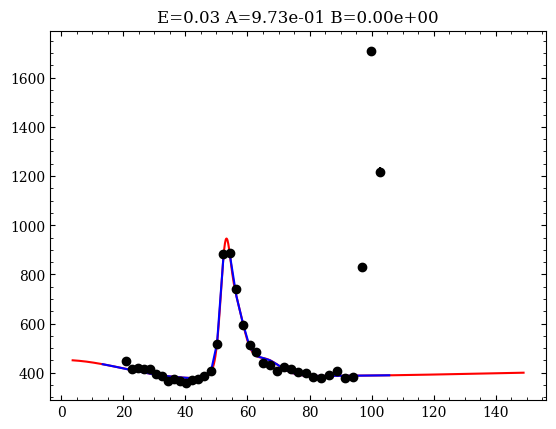

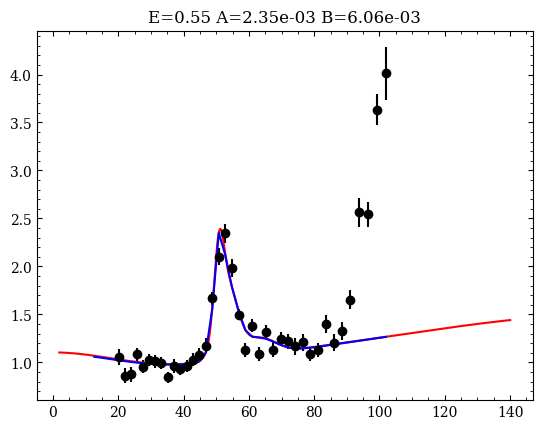

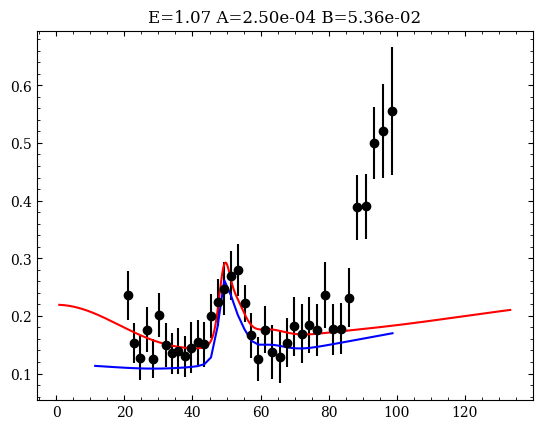

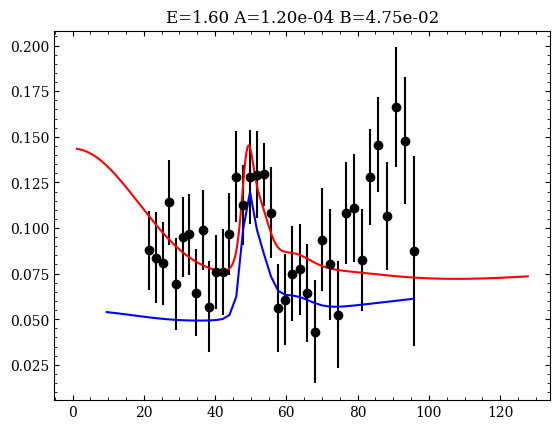

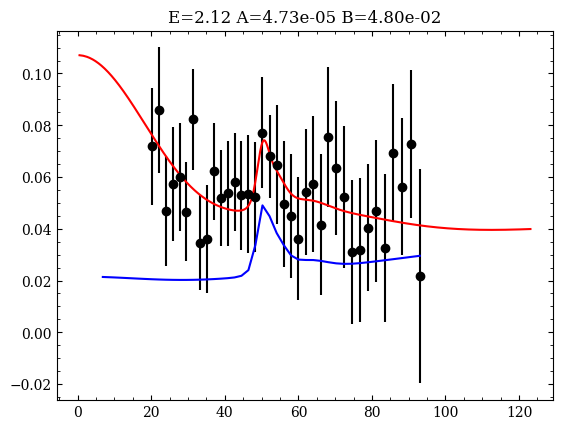

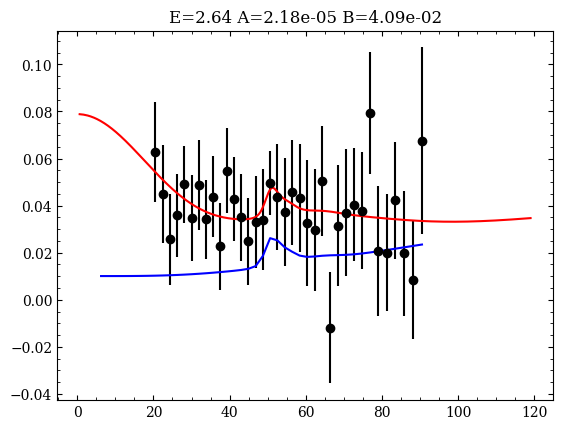

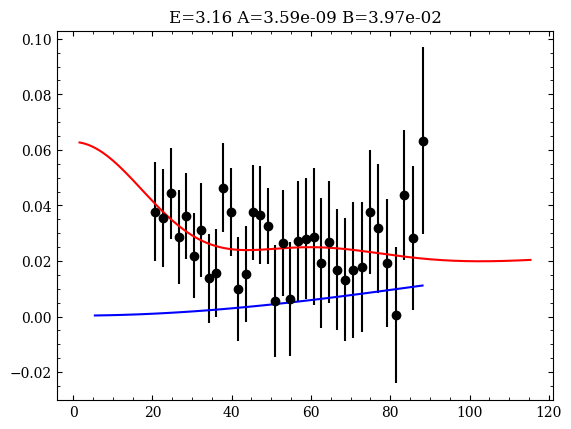

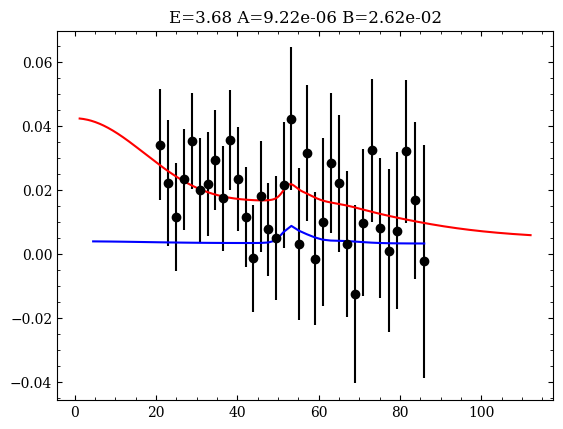

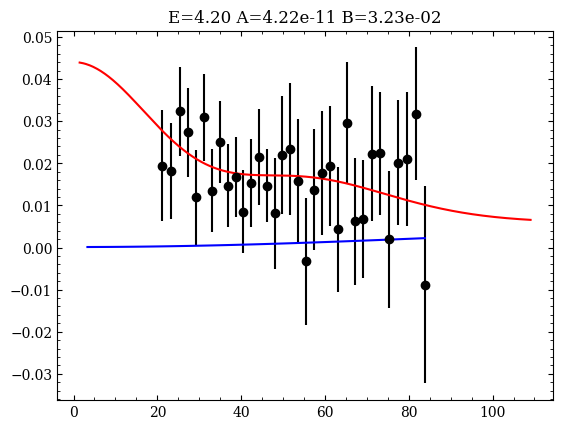

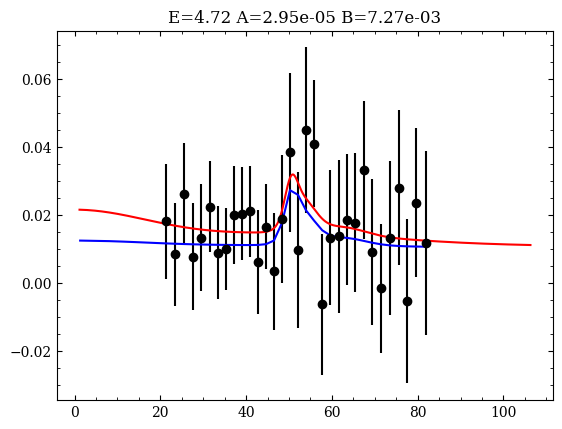

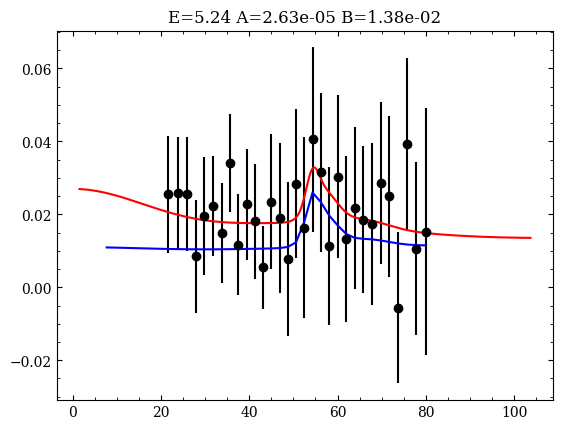

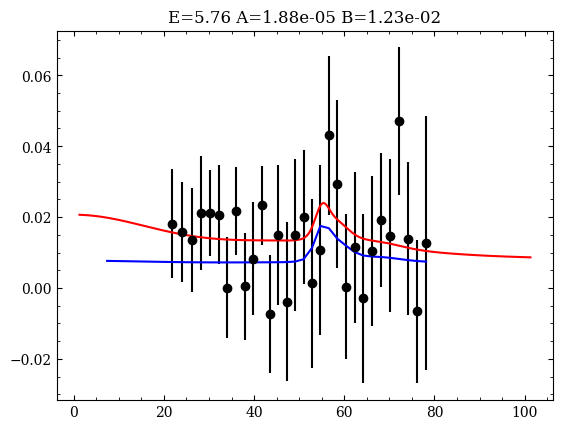

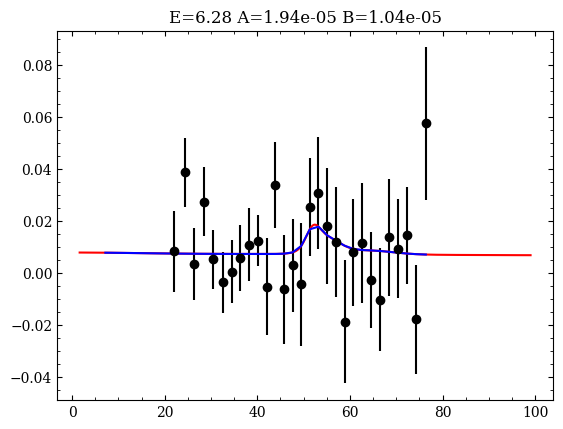

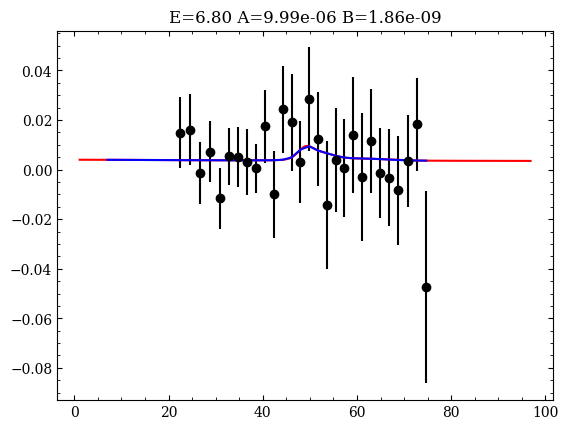

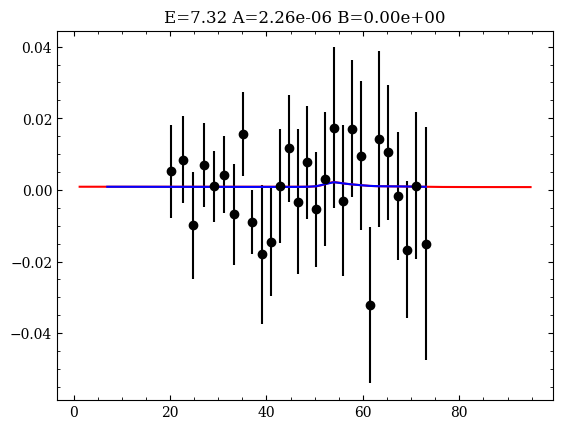

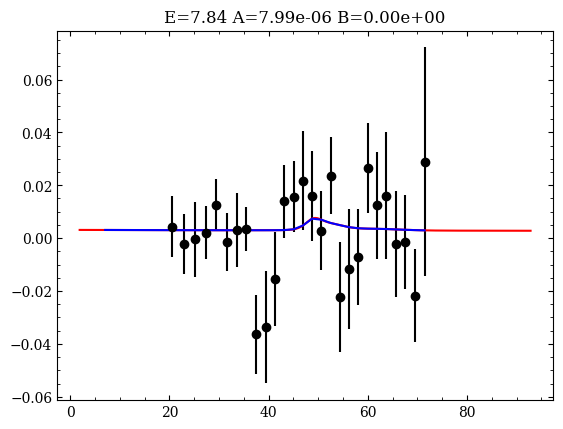

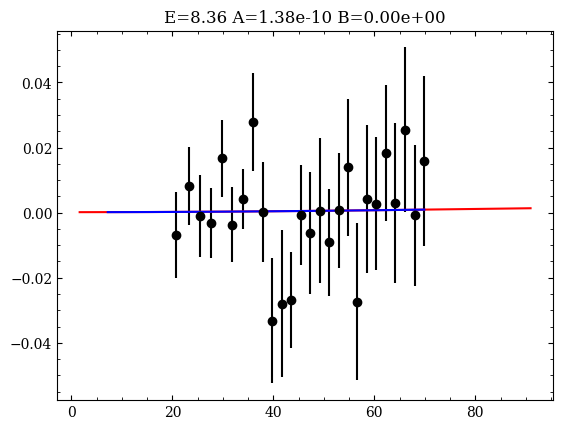

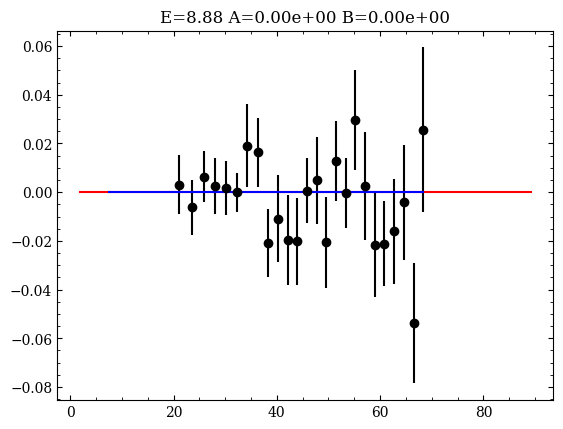

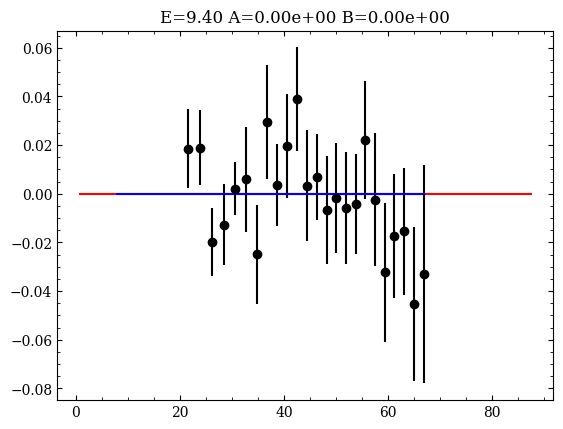

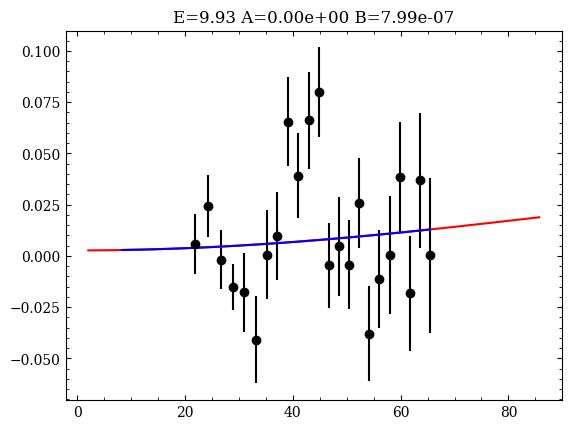

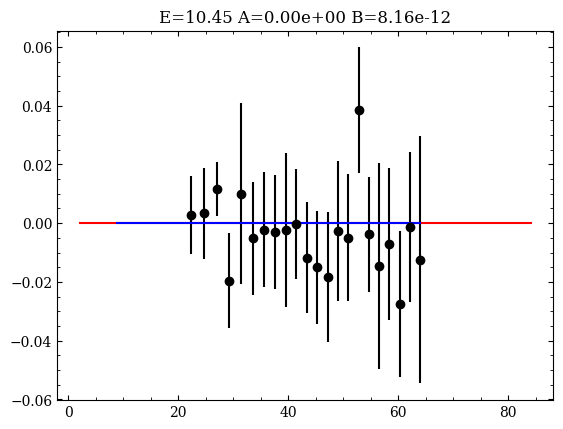

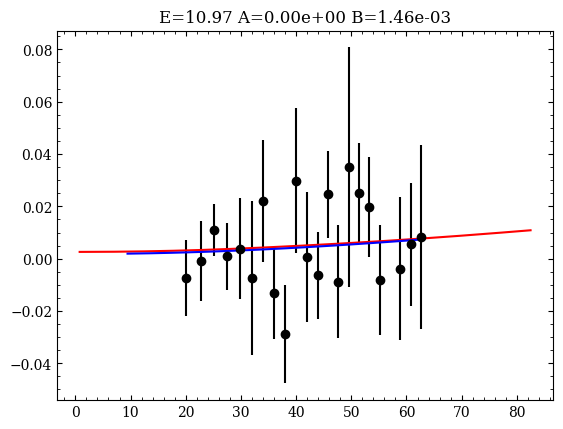

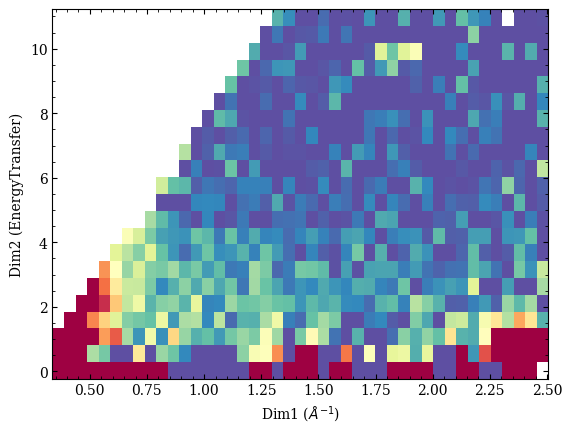

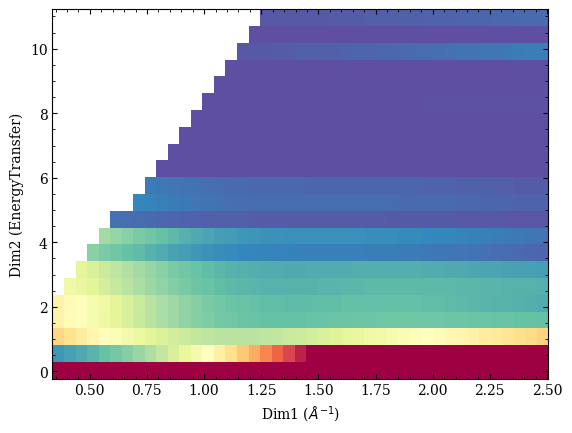

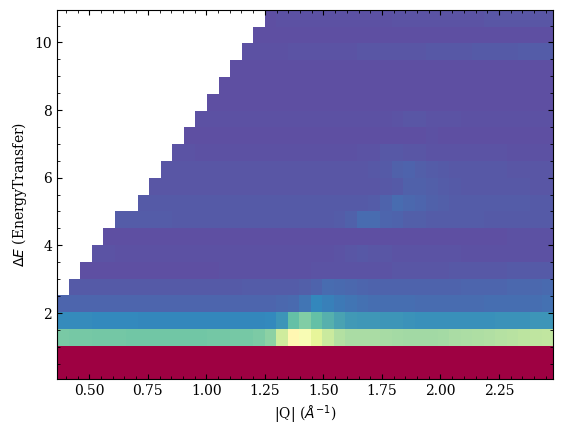

In [7]:
plt.close('all')
def el_line5(x,q,A,delta,old_model=HLIO_el_model5,old_result=HLIO_result5):
    #Using the previous fits, simply scale the overall lineshape. 
    old_params = old_result.params
    elline_eval=old_model.eval(x=x-delta,q=q,params=old_params)
    return A*elline_eval
def fake_phonon(q,P):
    return P*(q**2)
inel_model5 = Model(el_line5,independent_vars=['q','x'])\
        +Model(mag,independent_vars=['q'])+Model(fake_phonon,independent_vars=['q'])
inel_params5 = inel_model5.make_params()
inel_params5.add('A',value=1.0,min=0.0,max=1.0)
inel_params5.add('delta',vary=True,value=0.0,min=-4.0,max=2.0)#allow small shift of main peak
inel_params5.add('b',value=0.0,min=0.0,max=100.0)
inel_params5.add('P',vary=True,value=0.0,min=0.0,max=100.0)
#Using the previous lineshape, now only fit the relative bragg peak intensity as a function of energy transfer
I5 = np.copy(Ibar_5p0.getSignalArray())
I_out5 = np.copy(I5)
Bkg_5 = np.zeros(np.shape(I5))
Mag_5 = np.copy(I5)
Bkg_5[np.isnan(I5)]=np.nan
Errs5 = np.sqrt(np.copy(Ibar_5p0.getErrorSquaredArray()))
dims5 = Ibar_5p0.getNonIntegratedDimensions()
q5 = mdu.dim2array(dims5[0])
e5 = mdu.dim2array(dims5[1])

delta5_arr = []
A5_arr=[]
B_arr=[]
prev_A = 1.0
prev_b = 0
prev_incA = HLIO_result5.params['inc_a'].value
for i in range(len(e5)):
    qcut = np.copy(I5[:,i])
    zero_ind = [qcut==0]
    errcut = Errs5[:,i]
    weights = 1.0/errcut
    weights[np.isnan(qcut)]=0
    weights[qcut==0]=0
    weights[np.isinf(weights)]=0
    #qcut[weights==0]=0
    q0 = 1.4
    e_cut = e5[i]
    Ef = 5.0
    Ei = Ef + e_cut
    ki = np.sqrt(Ei/2.07)
    kf = np.sqrt(Ef/2.07)

    twoTheta = np.arccos((ki**2 + kf**2 - q5**2 )/ (2.0*ki*kf))*180.0/np.pi
    #Only fit area around peak
    weights[twoTheta>80.0]=0
    weights[twoTheta<25.0]=0
    #Construct our model using last fit params
    if e_cut>8.5:
        Avary=False
        prev_A=0
    else:
        Avary=True
        
    inel_params5.add('A',value=prev_A,min=0.0,max=5.0,vary=Avary)
    if i==0:
        inel_params5.add('b',vary=False,value=0,min=0,max=1e3)
    else:
        inel_params5.add('b',vary=True,value=prev_b,min=0,max=1e3)
    result5 = inel_model5.fit(qcut,q=q5,x=twoTheta,params=inel_params5,method='powell',\
                             weights=weights,nan_policy='omit')
    prev_A = result5.params['A'].value
    prev_b = result5.params['b'].value
    plt.figure()
    qcut[twoTheta<20.0]=np.nan
    plt.errorbar(twoTheta,qcut,yerr=errcut,color='k',marker='o',ls=' ')
    q_eval = np.linspace(0.1,3.0,1000)
    twoTheta_eval = np.arccos((ki**2 + kf**2 - q_eval**2 )/ (2.0*ki*kf))*180.0/np.pi
    result_eval = inel_model5.eval(x=twoTheta_eval,q=q_eval,params=result5.params)
    plt.plot(twoTheta_eval,result_eval,'r-')
    plt.title(f'E={e_cut:.2f} A={prev_A:.2e} B={prev_b:.2e}')
    twoTheta_eval = np.arccos((ki**2 + kf**2 - q5**2 )/ (2.0*ki*kf))*180.0/np.pi
    result5.params.add('b',value=0.0)
    result_eval = inel_model5.eval(x=twoTheta_eval,q=q5,params=result5.params)
    plt.plot(twoTheta_eval,result_eval,'b-')
    result5.params.add('b',value=prev_b)
    result5.params.add('A',value=0.0)
    mag_eval = inel_model5.eval(x=twoTheta_eval,q=q5,params=result5.params)
    Bkg_5[:,i]=result_eval
    I_out5[:,i]-=result_eval
    Mag_5[:,i]=mag_eval
    A5_arr.append(prev_A)
    delta5_arr.append(e_cut)

#Finally, make a new MDHisto and plot. 
mag_md_5 = Ibar_5p0.clone()
mag_md_5.setSignalArray(I_out5)
fig,ax = plt.subplots(1,1,subplot_kw={'projection':'mantid'})
ax.pcolormesh(mag_md_5,vmin=0,vmax=0.15,cmap='Spectral_r')

#Finally, make a new MDHisto and plot. 
mag_md_5_fit = Ibar_5p0.clone()
mag_md_5_fit.setSignalArray(Mag_5)
fig,ax = plt.subplots(1,1,subplot_kw={'projection':'mantid'})
ax.pcolormesh(mag_md_5_fit,vmin=0,vmax=0.15,cmap='Spectral_r')

#Put the background in an MDHisto as well. 
extents_str = str(np.min(q5))+','+str(np.max(q5))+','+str(np.min(e5))+','+str(np.max(e5))
numbin_str = str(len(np.unique(q5)))+','+str(len(np.unique(e5)))
I5_bkg_md = CreateMDHistoWorkspace(Dimensionality=2,Extents = extents_str,SignalInput=Bkg_5.T.flatten(),\
                               ErrorInput=Errs5.T.flatten(),Names='|Q|,DeltaE',\
                                Units='MomentumTransfer,EnergyTransfer',NumberOfBins=numbin_str)
fig,ax = plt.subplots(1,1,subplot_kw={'projection':'mantid'})
ax.pcolormesh(I5_bkg_md,cmap='Spectral_r',vmin=0,vmax=0.5)


SaveMD-[Notice] SaveMD started
Instrument-[Warning] Saving Instrument with no XML data. If this was instrument data you may not be able to load this data back into Mantid, for fitted/analysed data this warning can be ignored.
SaveMD-[Notice] SaveMD successful, Duration 0.03 seconds
SaveMD-[Notice] SaveMD started
Instrument-[Warning] Saving Instrument with no XML data. If this was instrument data you may not be able to load this data back into Mantid, for fitted/analysed data this warning can be ignored.
SaveMD-[Notice] SaveMD successful, Duration 0.02 seconds


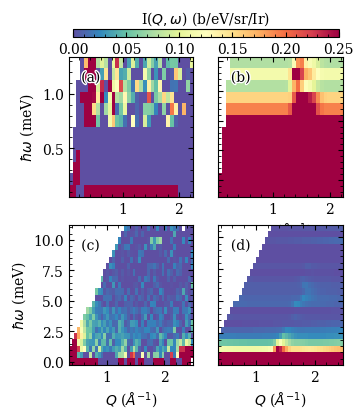

In [8]:
#Finally, make a figure showing the extracted magnetic scattering and backgrounds. 
#Also save the MDHistos for analysis later. 

cmap='Spectral_r'
fig,ax = plt.subplots(2,2,figsize=(3.54,4),subplot_kw={'projection':'mantid'})
mesh=ax[0,0].pcolormesh(mag_md_3p7,vmin=0,vmax=0.25,cmap=cmap,rasterized=True)
ax[0,1].pcolormesh(I3p7_bkg_md,vmin=0,vmax=0.25,cmap=cmap,rasterized=True)

ax[1,0].pcolormesh(mag_md_5,vmin=0,vmax=0.25,cmap=cmap,rasterized=True)
ax[1,1].pcolormesh(I5_bkg_md,vmin=0,vmax=0.25,cmap=cmap,rasterized=True)

ax[0,1].set_ylabel('')
ax[0,1].set_yticklabels([])
ax[1,1].set_ylabel('')
ax[1,1].set_yticklabels([])
ax[0,0].set_ylabel('$\hbar\omega$ (meV)')
ax[1,0].set_ylabel('$\hbar\omega$ (meV)')
ax[1,0].set_xlabel('$Q$ ($\AA^{-1}$)')
ax[1,1].set_xlabel('$Q$ ($\AA^{-1}$)')
ax[0,0].set_xlabel('')
txta = ax[0,0].text(0.1,0.9,'(a)',transform=ax[0,0].transAxes,horizontalalignment='left',\
            verticalalignment='top')
txtb = ax[0,1].text(0.1,0.9,'(b)',transform=ax[0,1].transAxes,horizontalalignment='left',\
            verticalalignment='top')
txtc = ax[1,0].text(0.1,0.9,'(c)',transform=ax[1,0].transAxes,horizontalalignment='left',\
            verticalalignment='top')
txtd = ax[1,1].text(0.1,0.9,'(d)',transform=ax[1,1].transAxes,horizontalalignment='left',\
            verticalalignment='top')
for txt in [txta,txtb,txtc,txtd]:
    txt.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Add a colorbar on top . 
l,b,w,h=ax[0,0].get_position().bounds
cax = fig.add_axes([l+0.0125,b+0.4,0.75,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/Ir)'
cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax)
cax.text(0.5,1.25,labelstr,horizontalalignment='center',verticalalignment='bottom',transform=cax.transAxes)
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

fig.savefig('MACS_elastic_bkg_extraction.pdf',bbox_inches='tight',dpi=300)

outdir = "../MDHisto_files/"
SaveMD(mag_md_5,outdir+'HLIO_MACS_5p0_mag.nxs')
SaveMD(mag_md_3p7,outdir+'HLIO_MACS_3p7_mag.nxs')


In [9]:
HLIO_result5.params

Parameters([('g1_a', <Parameter 'g1_a', value=1189.4576531710222, bounds=[0:100000.0]>), ('g1_x0', <Parameter 'g1_x0', value=53.02939045685268, bounds=[40.0:65.0]>), ('g1_sigma', <Parameter 'g1_sigma', value=1.4489040547343799, bounds=[1.0:5.2]>), ('g2_a', <Parameter 'g2_a', value=1009.652975905373, bounds=[0:100000.0]>), ('g2_x0', <Parameter 'g2_x0', value=64.99999987842196, bounds=[45.0:65.0]>), ('g2_sigma', <Parameter 'g2_sigma', value=5.199990133479476, bounds=[1.0:5.2]>), ('g3_a', <Parameter 'g3_a', value=2542.658591903463, bounds=[0:100000.0]>), ('g3_x0', <Parameter 'g3_x0', value=55.482944785254325, bounds=[45.0:65.0]>), ('g3_sigma', <Parameter 'g3_sigma', value=3.10839411707074, bounds=[1.0:5.2]>), ('inc_a', <Parameter 'inc_a', value=343.89480038202925, bounds=[10.0:100000.0]>), ('mag_b', <Parameter 'mag_b', value=60.55037379730066, bounds=[0:10000.0]>), ('ph_P', <Parameter 'ph_P', value=nan, bounds=[-inf:inf]>), ('P', <Parameter 'P', value=0.0 (fixed), bounds=[0.0:1000.0]>)])

CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.02 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds
CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.01 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.00 seconds


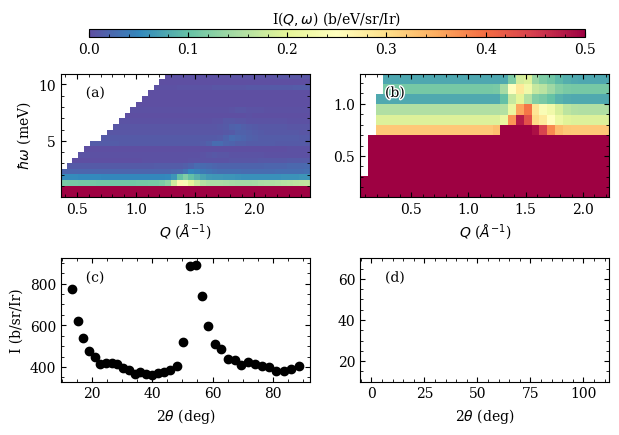

In [10]:
# Dissertation Version
#Finally, make a figure showing the extracted magnetic scattering and backgrounds. 
#Also save the MDHistos for analysis later. 
'''
plt.figure()
plt.errorbar(twoTheta,I3_elplot,yerr=ErrQ3_mag,color='k',marker='o')
plt.plot(twoTheta,HLIO_el_model.eval(x=twoTheta,q=q3_mag,params=HLIO_result.params),'r-')
plt.plot(twoTheta,comps['g1_'],'c--')
plt.plot(twoTheta,comps['g2_'],'m--')
plt.plot(twoTheta,comps['g3_'],'g--')
plt.plot(twoTheta,comps['inc_'],'b--')
plt.xlabel('$2\Theta$ (deg)',fontsize=16)
plt.ylabel('I(a.u.)',fontsize=16)
plt.title('E=0.2 meV Cut of MACS HLIO data')
plt.show()

plt.figure()
plt.errorbar(twoTheta5,I5_elplot,yerr=ErrQ5_mag,color='k',marker='o')
plt.plot(twoTheta5,HLIO_el_model.eval(x=twoTheta5,q=q5_mag,params=HLIO_result5.params),'r-')
plt.plot(twoTheta5,comps5['g1_'],'c--')
plt.plot(twoTheta5,comps5['g2_'],'m--')
plt.plot(twoTheta5,comps5['g3_'],'g--')
plt.plot(twoTheta5,comps5['inc_'],'b--')

plt.xlabel('$2\Theta$ (deg)',fontsize=16)
plt.ylabel('I(a.u.)',fontsize=16)
plt.title('E=0.2 meV Cut of MACS HLIO data')
plt.show()
'''
cmap='Spectral_r'
fig,ax = plt.subplots(2,2,figsize=(3.54*2,4),subplot_kw={'projection':'mantid'})
fig.subplots_adjust(wspace=0.2,hspace=0.5)
mesh=ax[0,1].pcolormesh(I3p7_bkg_md,vmin=0,vmax=0.5,cmap=cmap,rasterized=True)
ax[0,0].pcolormesh(I5_bkg_md,vmin=0,vmax=0.5,cmap=cmap,rasterized=True)

#q3_mag,I3_mag,ErrQ3_mag = cut_MDHisto_powder(Ibar_3p7,'|Q|',[0.3,2.5,0.01],[-0.1,0.35])
ax[1,1].errorbar(twoTheta3,I3_elplot,yerr=ErrQ3_mag,color='k',marker='o',ls=' ')
ax[1,0].errorbar(twoTheta5,I5_elplot,yerr=ErrQ5_mag,color='k',marker='o',ls=' ')
twoThetaTest = np.linspace(0,100,1000)
#Convert to Q
e_arr = mdu.dim2array(Ibar_3p7.getNonIntegratedDimensions()[1])
etrans = e_arr[0]
Ef = 3.7
Ei = Ef + etrans
ki = np.sqrt(Ei/2.07)
kf = np.sqrt(Ef/2.07)
Q3_test = np.sqrt(ki**2 + kf**2 - 2.0*ki*kf*np.cos(twoThetaTest))
e_arr = mdu.dim2array(Ibar_5p0.getNonIntegratedDimensions()[1])
etrans = e_arr[0]
Ef = 5.0
Ei = Ef + etrans
ki = np.sqrt(Ei/2.07)
kf = np.sqrt(Ef/2.07)
Q5_test = np.sqrt(ki**2 + kf**2 - 2.0*ki*kf*np.cos(twoThetaTest))

HLIO_result5.params['mag_b'].value=0
ax[1,0].plot(twoThetaTest,HLIO_el_model.eval(x=twoThetaTest,q=Q5_test,params=HLIO_result5.params),'r-')
ax[1,1].plot(twoThetaTest,HLIO_el_model.eval(x=twoThetaTest,q=Q3_test,params=HLIO_result.params),'r-')
#ax[0,1].set_ylabel('')
#ax[0,1].set_yticklabels([])
ax[1,1].set_ylabel('')
ax[0,1].set_ylabel('')
ax[1,1].set_ylim(10,70)
#ax[1,1].set_yticklabels([])
ax[0,0].set_ylabel('$\hbar\omega$ (meV)')
#ax[0,1].set_ylabel('$\hbar\omega$ (meV)')
ax[1,0].set_ylabel('I (b/sr/Ir)')
ax[0,0].set_xlabel('$Q$ ($\AA^{-1}$)')
ax[0,1].set_xlabel('$Q$ ($\AA^{-1}$)')
ax[1,0].set_xlabel(r'2$\theta$ (deg)')
ax[1,1].set_xlabel(r'2$\theta$ (deg)')
txta = ax[0,0].text(0.1,0.9,'(a)',transform=ax[0,0].transAxes,horizontalalignment='left',\
            verticalalignment='top')
txtb = ax[0,1].text(0.1,0.9,'(b)',transform=ax[0,1].transAxes,horizontalalignment='left',\
            verticalalignment='top')
txtc = ax[1,0].text(0.1,0.9,'(c)',transform=ax[1,0].transAxes,horizontalalignment='left',\
            verticalalignment='top')
txtd = ax[1,1].text(0.1,0.9,'(d)',transform=ax[1,1].transAxes,horizontalalignment='left',\
            verticalalignment='top')
for txt in [txta,txtb,txtc,txtd]:
    txt.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Add a colorbar on top . 
l,b,w,h=ax[0,0].get_position().bounds
cax = fig.add_axes([l+0.04,b+0.4,0.7,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/Ir)'
cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax)
cax.text(0.5,1.25,labelstr,horizontalalignment='center',verticalalignment='bottom',transform=cax.transAxes)
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
fig.savefig('MACS_elastic_bkg_extraction_dissertation.pdf',bbox_inches='tight',dpi=300)

CreateWorkspace-[Notice] CreateWorkspace started
CreateWorkspace-[Notice] CreateWorkspace successful, Duration 0.02 seconds
MagFormFactorCorrection-[Notice] MagFormFactorCorrection started
MagFormFactorCorrection-[Notice] MagFormFactorCorrection successful, Duration 0.01 seconds


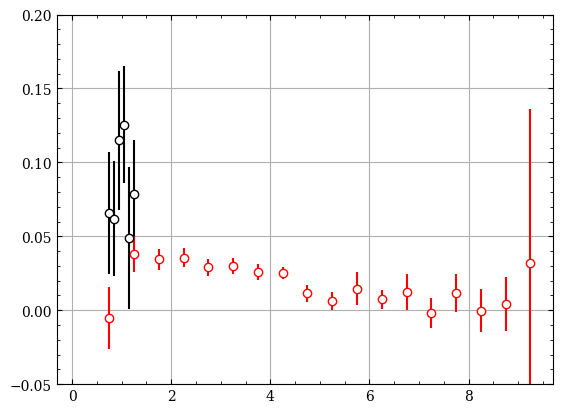

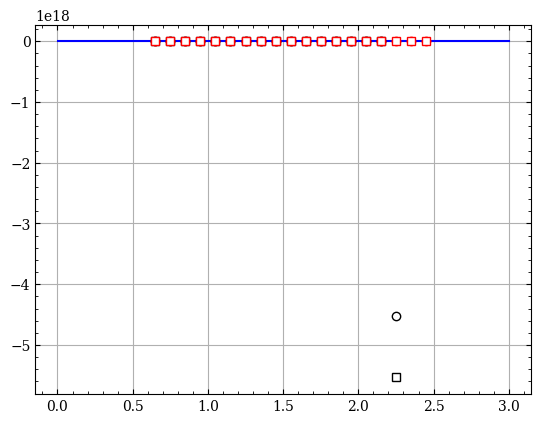

In [11]:
# plots of cuts 



fig,ax = plt.subplots(1,1)
ecut3,icut3,errcut3 = cut_MDHisto_powder(mag_md_3p7,'DeltaE',[0.0,1.5,0.1],[0.7,1.2])
ecut5,icut5,errcut5 = cut_MDHisto_powder(mag_md_5,'DeltaE',[0.5,10.0,0.5],[0.7,1.2])

ax.errorbar(ecut3,icut3,errcut3,color='k',marker='o',mfc='w',mec='k',ls=' ')
ax.errorbar(ecut5,icut5,errcut5,color='r',marker='o',mfc='w',mec='r',ls=' ')
ax.set_ylim(-0.05,0.2)
ax.grid('on')


fig,ax=plt.subplots(1,1)
qcut3_orig,iq3_orig,errq3_orig = cut_MDHisto_powder(mtd['2K_3p7'],'|Q|',[0.6,3,0.1],[0.8,1.3])
qcut5_orig,iq5_orig,errq5_orig = cut_MDHisto_powder(mtd['2K_5p0'],'|Q|',[0.6,3,0.1],[2,4])


qcut3,iqcut3,errqcut3 = cut_MDHisto_powder(mag_md_3p7,'|Q|',[0.6,3,0.1],[0.8,1.3])
qcut5,iqcut5,errqcut5 = cut_MDHisto_powder(mag_md_5,'|Q|',[0.6,3,0.1],[2,4])
ax.plot(np.linspace(0,3,1000),mag(np.linspace(0,3,1000),0.06),'b-')
ax.errorbar(qcut3,iqcut3,errqcut3,color='k',marker='o',mfc='w',mec='k',ls=' ')
ax.errorbar(qcut3_orig,iq3_orig,errq3_orig,color='k',marker='s',mfc='w',mec='k',ls=' ')

ax.errorbar(qcut5,iqcut5,errqcut5,color='r',marker='o',mfc='w',mec='r',ls=' ')
ax.errorbar(qcut5_orig,iq5_orig,errq5_orig,color='r',marker='s',mfc='w',mec='r',ls=' ')
#ax.set_ylim(-0.05,0.15)
ax.grid('on')

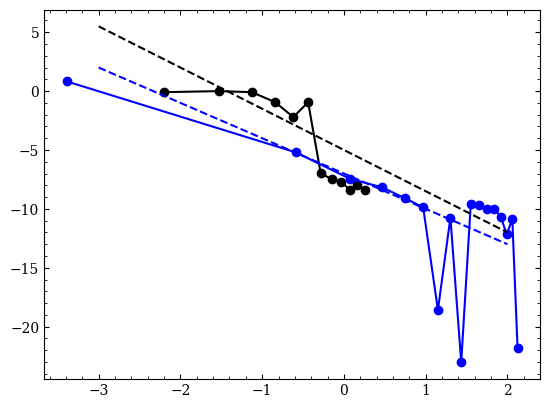

In [12]:
plt.figure()
plt.plot(np.log(delta3_arr),np.log(A3_arr),'ko',ls='-')
plt.plot(np.log(delta5_arr),np.log(np.array(A5_arr)*2.35),'bo',ls='-')
def lin(x,m,b):
    return m*x+b

x=np.linspace(-3,2,1000)
plt.plot(x,lin(x,-3.5,-5),'k--')
plt.plot(x,lin(x,-3,-7),'b--')
#plt.ylim(1e-6,0.4)
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,9)